# Final Capstone Project - J Lee
### Using Local Schools with FourSquare Data to Find Like-Neighbourhoods

#### Step 1: Gather and Clean School and School Location Data from
 - The Fraser Institute (https://www.fraserinstitute.org/school-performance)
 - geopy.geocoders 

In [1]:
# get the required table from wikipedia
import pandas as pd
import numpy as np
import requests
from pandas import ExcelWriter
from pandas import ExcelFile
'''
The school data comes from http://ontario.compareschoolrankings.org/elementary/SchoolsByRankLocationName.aspx
due to the nature of this site, the data was converted to a csv file before uploading.
'''

schools_df = pd.read_excel('schools.xlsx')
# remove divisor from rank data leaving actual rank out of 3044 Ontario schools
split = schools_df['2017-18 Rank'].str.split("/", n=1, expand=True)

split[0].replace('','0', inplace=True)

# if rank value missing, apply tha average, then reassign the value, rename the column and drop original
split[0].fillna(split[0].mean())
split[0] = split[0].astype(int)

schools_df['Rank/3046'] = split[0]
schools_df.drop(columns=['2017-18 Rank'], axis=1, inplace=True)

# ensure numeric values are float for the Rating column
schools_df['2017-18 Rating'] = schools_df['2017-18 Rating'].astype(float)

schools_df.head()

,School Name,City,2017-18 Rating,Rank/3046
0,Abraham Erb,Waterloo,8.5,144
1,Laurelwood,Waterloo,8.2,213
2,Our Lady of Lourdes,Waterloo,7.9,334
3,Millen Woods,Waterloo,7.8,388
4,Lexington,Waterloo,7.5,559


In [2]:
schools_df.describe(include='all')
# quick overview of the data table

,School Name,City,2017-18 Rating,Rank/3046
count,81,81,81.000000,81.000000
unique,81,2,NaN,NaN
top,St Mark,Kitchener,NaN,NaN
freq,1,54,NaN,NaN
mean,NaN,NaN,6.023457,1497.580247
std,NaN,NaN,1.414768,824.524907
min,NaN,NaN,2.300000,0.000000
25%,NaN,NaN,5.100000,740.000000
50%,NaN,NaN,6.200000,1470.000000
75%,NaN,NaN,7.200000,2210.000000


In [3]:
schools_df.shape

(81, 4)

#### Step 2: Clean the school data and add latitude and longitude coordinates for each school

In [4]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_school_data")

coords = []

for ind, row in schools_df.iterrows():
    loc_str1 = row[0] + ' Public School, ' + row[1] # find and get coordinates for public schools
    loc_str2 = row[0] + ', ' + row[1] # attempt to find and get coordinates for Catholic and independent schools
    location = geolocator.geocode(loc_str1)
    if location:
        coords.append([row[0],location.latitude, location.longitude])
    else:
        # if the school is not Public, try again without "Public School" in the name
        location = geolocator.geocode(loc_str2)
        if  location:
            coords.append([row[0],location.latitude, location.longitude])

coords_df = pd.DataFrame(coords)
coords_df.shape

(69, 3)

In [5]:
coords_df.dropna(inplace=True) # remove any schools without coordinates
coords_df.shape

(69, 3)

In [6]:
# clean-up the dataframe, add labels
coords_df.rename(columns={0:'School Name',1:'Latitude',2:'Longitude'}, inplace=True)
coords_df.head(10)

,School Name,Latitude,Longitude
0,Abraham Erb,43.470070,-80.597760
1,Laurelwood,43.469265,-80.574892
2,Our Lady of Lourdes,43.458840,-80.531052
3,Millen Woods,43.513493,-80.504685
4,Lexington,43.501287,-80.496724
5,St Nicholas,42.506569,-92.305409
6,Mère-Élisabeth-Bruyère,43.483415,-80.510190
7,Elizabeth Ziegler,43.465247,-80.511895
8,Mary Johnston,43.458490,-80.563629
9,Northlake Woods,43.496372,-80.564813


In [7]:
schools_df.head(3)

,School Name,City,2017-18 Rating,Rank/3046
0,Abraham Erb,Waterloo,8.5,144
1,Laurelwood,Waterloo,8.2,213
2,Our Lady of Lourdes,Waterloo,7.9,334


In [8]:
# normalize the Rank and Rating data for later use (reduce weight by factor of 10 for future comparison)
schools_df['Rating_normalized'] = schools_df['2017-18 Rating']/(schools_df['2017-18 Rating'].max()*10)
schools_df['Rank_normalized'] = schools_df['Rank/3046']/(3046*10)
schools_df.head(4)

,School Name,City,2017-18 Rating,Rank/3046,Rating_normalized,Rank_normalized
0,Abraham Erb,Waterloo,8.5,144,0.100000,0.004728
1,Laurelwood,Waterloo,8.2,213,0.096471,0.006993
2,Our Lady of Lourdes,Waterloo,7.9,334,0.092941,0.010965
3,Millen Woods,Waterloo,7.8,388,0.091765,0.012738


In [9]:
# Add coordinate information to the schools_df
schools_df = schools_df.join(coords_df.set_index('School Name'), on='School Name')

In [10]:
# remove any rows with empty cells
schools_df.dropna(inplace=True)
schools_df.head()

,School Name,City,2017-18 Rating,Rank/3046,Rating_normalized,Rank_normalized,Latitude,Longitude
0,Abraham Erb,Waterloo,8.5,144,0.100000,0.004728,43.470070,-80.597760
1,Laurelwood,Waterloo,8.2,213,0.096471,0.006993,43.469265,-80.574892
2,Our Lady of Lourdes,Waterloo,7.9,334,0.092941,0.010965,43.458840,-80.531052
3,Millen Woods,Waterloo,7.8,388,0.091765,0.012738,43.513493,-80.504685
4,Lexington,Waterloo,7.5,559,0.088235,0.018352,43.501287,-80.496724


In [11]:
# save data to csv for easier import in future
schools_df.to_csv(r'schools_data_exp.csv')

In [12]:
# plot a base map of all the schools - not clustered to test the data
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Waterloo, Ontario, Canada'  # base of map

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
# get coordinated for Waterloo city center and print the results
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Waterloo are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Waterloo are 43.466874, -80.524635.


In [13]:
import folium # map rendering library

# create map of Waterloo using latitude and longitude values
map_KW = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markersfor the identified schools to map from the schools_df data
for lat, lng, school, city in zip(schools_df['Latitude'], schools_df['Longitude'], schools_df['School Name'], schools_df['City']):
    label = '{}; {}'.format(school, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_KW)  
    
map_KW

<img src="schools.png">

#### Data can now be imported for use in other notebooks, and to avoid the time it take to rerun the extractions each session

### Step 3: Create a baseline representation of clustering schools based only on the Fraser Institute Rank and Rating data

In [14]:
# import the data from csv
schools_df = pd.read_csv('schools_data_exp.csv')
schools_df.sort_values(by=['School Name'], inplace=True)
schools_df.reset_index(inplace=True)

# create a dataframe for use with the K mean cluster method
schools_data_k = schools_df[['Rating_normalized','Rank_normalized']].copy()

schools_data_k.head(3)

,Rating_normalized,Rank_normalized
0,0.027059,0.096881
1,0.100000,0.004728
2,0.084706,0.024294


Text(0.5, 1.0, 'Sum of Squares Distance vs. Number of k-clusters')

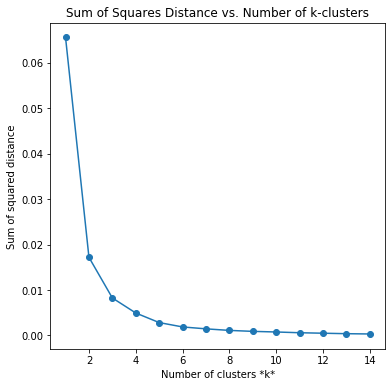

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# EVALUATE K: Run the Kmeans algorithm for valuse of k between 1 and 14 and get the index of data points clusters
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(schools_data_k)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title('Sum of Squares Distance vs. Number of k-clusters')

In [17]:
# select k=4 as the best number of clusters based on the 'elbow test'
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(schools_data_k)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 0, 0, 2, 3, 0, 3, 3], dtype=int32)

In [18]:
# add clustering labels to the orifinal schools_df for plotting

schools_df.insert(0, 'Cluster Labels', kmeans.labels_)
schools_df.drop(['index','Unnamed: 0'], axis=1, inplace=True)
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#schools_merged = schools_merged.join(schools_venues_sorted.set_index('School Name'), on='School Name')

#schools_merged.head() # check the dataframe
schools_df.head()

,Cluster Labels,School Name,City,2017-18 Rating,Rank/3046,Rating_normalized,Rank_normalized,Latitude,Longitude
0,1,A R Kaufman,Kitchener,2.3,2951,0.027059,0.096881,43.442319,-80.523868
1,2,Abraham Erb,Waterloo,8.5,144,0.100000,0.004728,43.470070,-80.597760
2,2,Alpine,Kitchener,7.2,740,0.084706,0.024294,43.420093,-80.480740
3,0,Blessed Sacrament,Kitchener,6.0,1616,0.070588,0.053053,43.407401,-80.483610
4,0,Bridgeport,Kitchener,6.8,1024,0.080000,0.033618,43.482794,-80.486665


In [19]:
# plot the results of clustering based on EQAO (Fraser) data only

address = 'Waterloo, Ontario, Canada'  # base of map

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)

# get coordinated for KW center 
latitude = location.latitude
longitude = location.longitude

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
from geopy.geocoders import Nominatim

# create the KW map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rank in zip(schools_df['Latitude'], schools_df['Longitude'], schools_df['School Name'], schools_df['Cluster Labels'], schools_df['2017-18 Rating']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Rating: ' + str(rank), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save("schools.jpg")
map_clusters

<img src="schools_cluster_FI_only.png">

### Step 4: Including FourSquare Data in the Clustering Approach

In [20]:
# re-import the schools_df data for re-analysis
schools_df = pd.read_csv('schools_data_exp.csv')
schools_df.sort_values('School Name', inplace=True)
schools_df.drop('Unnamed: 0', axis=1, inplace=True)
schools_df.reset_index(inplace=True)
schools_df.drop('index',axis=1,inplace=True)
schools_df.head()

,School Name,City,2017-18 Rating,Rank/3046,Rating_normalized,Rank_normalized,Latitude,Longitude
0,A R Kaufman,Kitchener,2.3,2951,0.027059,0.096881,43.442319,-80.523868
1,Abraham Erb,Waterloo,8.5,144,0.100000,0.004728,43.470070,-80.597760
2,Alpine,Kitchener,7.2,740,0.084706,0.024294,43.420093,-80.480740
3,Blessed Sacrament,Kitchener,6.0,1616,0.070588,0.053053,43.407401,-80.483610
4,Bridgeport,Kitchener,6.8,1024,0.080000,0.033618,43.482794,-80.486665


In [21]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# prepart to gather Foursquare data
CLIENT_ID = '443E05IF1V3S2NAHVOA0CIDJGJQ1NNZZ2MH14NYFVXBGGG2K' # your Foursquare ID
CLIENT_SECRET = 'S13WDCLFB4JU44WNKX2ANWFXQGQGB0JXT4AOKZCW0AE0ZZ54' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# What can we learn about similar neighbourhoods when schools are considered the hub of neighbourhoods?

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            50)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
#get a subset of venues for KW sities around schools from Foursquare
KW_df = schools_df

# get the nearby venues for the schools
schools_venues = getNearbyVenues(names=KW_df['School Name'],
                                   latitudes=KW_df['Latitude'],
                                   longitudes=KW_df['Longitude']
                                  )

A R Kaufman
Abraham Erb
Alpine
Blessed Sacrament
Bridgeport
Brigadoon
Canadian Martyrs
Cardinal-Léger
Cedarbrae
Chicopee Hills
Country Hills
Crestview
Driftwood Park
Edna Staebler
Elizabeth Ziegler
Empire
Forest Hill
Franklin
Glencairn
Groh
Holy Rosary
Howard Robertson
J F Carmichael
J W Gerth
Jean Steckle
John Darling
John Sweeney
Keatsway
King Edward
L'Harmonie
Lackner Woods
Laurelwood
Lester B Pearson
Lexington
Lincoln Heights
MacKenzie King
Mary Johnston
Meadowlane
Millen Woods
Monsignor Haller
Mère-Élisabeth-Bruyère
N A MacEachern
Northlake Woods
Our Lady of Lourdes
Pioneer Park
Prueter
Queen Elizabeth
Rockway
Sandhills
Sandowne
Sheppard
Sir Edgar Bauer
Smithson
Southridge
St Agnes
St Aloysius
St John
St Luke
St Matthew
St Nicholas
Suddaby
Trillium
Vista Hills
W.T. Townshend
Westmount
Westvale
Williamsburg
Wilson Avenue
Winston Churchill


In [23]:
print(f"There are {schools_venues.shape[0]} total venues in Kitchener-Waterloo and {schools_venues['Venue Category'].nunique()} unique venue categories.")

There are 1337 total venues in Kitchener-Waterloo and 211 unique venue categories.


In [25]:
schools_venues.head(5)  # Check the data with Scarborough filter

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A R Kaufman,43.442319,-80.523868,Wendy's,43.440690,-80.521371,Fast Food Restaurant
1,A R Kaufman,43.442319,-80.523868,KW Gymnastics,43.437435,-80.524957,Gym / Fitness Center
2,A R Kaufman,43.442319,-80.523868,Heer's Paint & Decor - Benjamin Moore,43.444990,-80.522339,Furniture / Home Store
3,A R Kaufman,43.442319,-80.523868,Double Deal,43.440101,-80.526440,Pizza Place
4,A R Kaufman,43.442319,-80.523868,Onkar Foods and Spices,43.440051,-80.526782,Grocery Store


In [26]:
# 1337 KW venues with 211 unique categories

# one hot encoding in order to analyze the categorical data in the venues
schools_onehot = pd.get_dummies(schools_venues[['Venue Category']], prefix="", prefix_sep="")

# add school name column back to dataframe
schools_onehot['School Name'] = schools_venues['Neighborhood'] 

schools_onehot.shape

(1337, 212)

In [27]:
# move School Name column to the first column
fixed_columns = [schools_onehot.columns[-1]] + list(schools_onehot.columns[:-1])
schools_onehot = schools_onehot[fixed_columns]

schools_onehot.head()

,School Name,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,A R Kaufman,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A R Kaufman,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A R Kaufman,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A R Kaufman,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A R Kaufman,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# group by the onehot School Name, averaging the results to create a weighted value for each Venue Category
schools_grouped = schools_onehot.groupby('School Name').mean().reset_index()

schools_grouped.head()

,School Name,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,A R Kaufman,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abraham Erb,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0
2,Alpine,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,...,0.0,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Blessed Sacrament,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bridgeport,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
schools_grouped.shape
# check the shape of the data frame (expecting 16 boroughs in scarborough with 53 venue categories)

(68, 212)

In [30]:
# create a function that will sort the top venues for each neighborhood submitted in a data frame

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
import numpy as np
num_top_venues = 5  # get the 5 most popular venues for each neighbourhood

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['School Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
schools_venues_sorted = pd.DataFrame(columns=columns)
schools_venues_sorted['School Name'] = schools_grouped['School Name']


for ind in np.arange(schools_grouped.shape[0]):
    schools_venues_sorted.iloc[ind, 1:] = return_most_common_venues(schools_grouped.iloc[ind, :], num_top_venues)

schools_venues_sorted.head()

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,A R Kaufman,Pizza Place,Bakery,Grocery Store,Paintball Field,Furniture / Home Store
1,Abraham Erb,Park,Fast Food Restaurant,Pharmacy,Sandwich Place,Chinese Restaurant
2,Alpine,Convenience Store,Shopping Mall,Fast Food Restaurant,Pizza Place,Coffee Shop
3,Blessed Sacrament,Convenience Store,Bank,Park,Sandwich Place,Kids Store
4,Bridgeport,Coffee Shop,Sandwich Place,Mediterranean Restaurant,BBQ Joint,Supermarket


Text(0.5, 1.0, 'Sum of Squares Distance vs. Number of k-clusters')

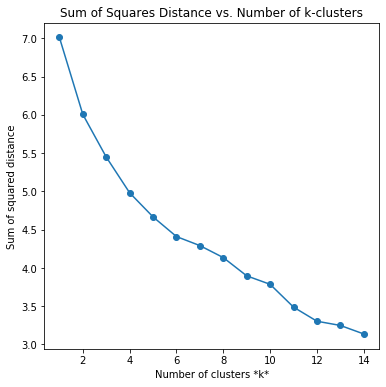

In [38]:
import matplotlib.pyplot as plt

# EVALUATE K: Run the Kmeans algorithm for valuse of k between 1 and 14 and get the index of data points clusters

sse = []
list_k = list(range(1, 15))
#remove name so not considered in clustering
schools_grouped_clustering = schools_grouped.drop('School Name', 1)
# Include Fraser Institute data in the analysis
schools_grouped_clustering['Rating_normalized'] = schools_df['Rating_normalized']
schools_grouped_clustering['Rank_normalized'] = schools_df['Rank_normalized']

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(schools_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title('Sum of Squares Distance vs. Number of k-clusters')

In [39]:
# set k=6 as the best number of clusters (most differentiation)
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(schools_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 3, 0, 2, 0, 3, 3, 2], dtype=int32)

In [40]:
# add clustering labels

schools_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

schools_merged = schools_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
schools_merged = schools_merged.join(schools_venues_sorted.set_index('School Name'), on='School Name')

schools_merged.head() # check the dataframe

,School Name,City,2017-18 Rating,Rank/3046,Rating_normalized,Rank_normalized,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,A R Kaufman,Kitchener,2.3,2951,0.027059,0.096881,43.442319,-80.523868,1.0,Pizza Place,Bakery,Grocery Store,Paintball Field,Furniture / Home Store
1,Abraham Erb,Waterloo,8.5,144,0.100000,0.004728,43.470070,-80.597760,3.0,Park,Fast Food Restaurant,Pharmacy,Sandwich Place,Chinese Restaurant
2,Alpine,Kitchener,7.2,740,0.084706,0.024294,43.420093,-80.480740,3.0,Convenience Store,Shopping Mall,Fast Food Restaurant,Pizza Place,Coffee Shop
3,Blessed Sacrament,Kitchener,6.0,1616,0.070588,0.053053,43.407401,-80.483610,3.0,Convenience Store,Bank,Park,Sandwich Place,Kids Store
4,Bridgeport,Kitchener,6.8,1024,0.080000,0.033618,43.482794,-80.486665,0.0,Coffee Shop,Sandwich Place,Mediterranean Restaurant,BBQ Joint,Supermarket


In [41]:
#toronto_merged = toronto_merged[[toronto_merged['Cluster Labels'] != 'nan']]
schools_merged['Cluster Labels'].replace([np.inf, -np.inf], np.nan)
schools_merged['Cluster Labels'].fillna(0, inplace=True)
schools_merged['Cluster Labels'] = schools_merged['Cluster Labels'].astype(int)
schools_merged['Cluster Labels'].value_counts()
# check to see how many of each cluster

0    25
1    19
3    18
5     3
2     3
4     1
Name: Cluster Labels, dtype: int64

In [42]:
# Plot the results showing grouping of schools with FourSquare and Fraser Data
address = 'Waterloo, Ontario, Canada'  # base of map

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
# get coordinated for Scarborough city center and print the results
latitude = location.latitude
longitude = location.longitude

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create the KW map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rank in zip(schools_merged['Latitude'], schools_merged['Longitude'], schools_merged['School Name'], schools_merged['Cluster Labels'], schools_merged['2017-18 Rating']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Rating: ' + str(rank), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save("schools.jpg")
map_clusters

<img src="schools_cluster_FI_and_FS.png">